This is an utility to generate SMARTS srings to be used when generating substructure-based fingerprints. The SMARTS we want to generate are the definitions of the substructures that we try to match to define each of the bits that constitute the substructure-based fingerprint.

Fist, we define the pathname to the file with the reference structure, i.e., the structure that we want to chop into pieces to make substructures that we then transforma into SMARTS:

In [1]:
pathToReference = "goal.sdf"

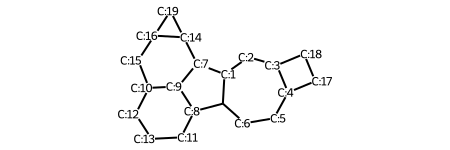

In [2]:
import glob
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import MolWt, HeavyAtomCount

molSupplier = Chem.SDMolSupplier(pathToReference, removeHs=False);

i=0
for mol in molSupplier:
    i=i+1
    if i > 1:
        raise TypeError("ERROR! SDF file is expected to contain only one molecule!")

# This is just to display a good-looking version of the reference molecule
# We make a copy to avoid setting the atom map number in the original molecule. 
# This because such number ends up in the SMARTS, and we do not want it there.
import copy
def mol_with_atom_index(mol):
    mol_copy = copy.deepcopy(mol)
    mol_copy = Chem.RemoveHs(mol_copy)
    AllChem.Compute2DCoords(mol_copy)
    for atom in mol_copy.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol_copy

mol_with_atom_index(mol)

In [3]:
ri = mol.GetRingInfo()

UNIQUE = {}
FRAGS = ()
SMARTS = ()

molHeavyAtoms = HeavyAtomCount(mol)

def make_fragment_from_these_atom_ids(ids_to_fragment):
    if len(ids_to_fragment) == mol.GetNumAtoms():
        print('Ignoring fragment that contains all atoms.')
        return
    rw_mol = copy.deepcopy(mol)
    fragment = Chem.RWMol(rw_mol)
    for aid in range(mol.GetNumAtoms()-1,-1,-1):
        if aid in ids_to_fragment:
            continue
        fragment.RemoveAtom(aid)
    if molHeavyAtoms == HeavyAtomCount(fragment):
        print('Ignoring fragment that contains all heavy atoms.')
        return
    cansmi = Chem.MolToSmiles(fragment)
    global UNIQUE
    if cansmi not in UNIQUE.keys():
        UNIQUE[cansmi] = fragment
        global FRAGS 
        FRAGS = FRAGS + (fragment,)
        global SMARTS
        SMARTS = SMARTS + (Chem.MolToSmarts(fragment),)
    else:
        print('Ignoring duplicate fragment.')
        return

# Generate fragments from shells of newigbors
for atm in mol.GetAtoms():
    if atm.GetSymbol() == 'H':
        continue
    ids_to_fragment = (atm.GetIdx(),)
    for shell_id in range(1,5):
        print('Shell',shell_id)
        prev_shell = ids_to_fragment
        for atmid in prev_shell:
            for nbr in mol.GetAtomWithIdx(atmid).GetNeighbors():
                nbr_id = nbr.GetIdx()
                if nbr_id not in ids_to_fragment:
                    ids_to_fragment = ids_to_fragment + (nbr_id,)
        print('IDs:',ids_to_fragment)
        make_fragment_from_these_atom_ids(ids_to_fragment)

# Generate fragments for rings (plus the atoms directly connected to the ring)
for ring in ri.AtomRings():
    # Identify which atoms belong to this ring's fragment, i.e., ring atoms plus nearest neigbors
    ids_to_fragment = ring
    #print('Ring:      ',ring)
    for i in ring:
        atm = mol.GetAtomWithIdx(i)
        for nbr in atm.GetNeighbors():
            if not nbr.GetIdx() in ring:
                ids_to_fragment = ids_to_fragment + (nbr.GetIdx(),)
    #print('  Fragment ',ids_to_fragment)
    make_fragment_from_these_atom_ids(ids_to_fragment)


# Generate fragments for rings with first shell of fused rings (plus the atoms directly connected to the ring)
for ring in ri.AtomRings():
    ids_to_fragment = ring
    #print('Ring:      ',ring)
    for i in ring:
        atm = mol.GetAtomWithIdx(i)
        for nbr in atm.GetNeighbors():
            nbr_id = nbr.GetIdx()
            #print(i,'NBO',nbr_id)
            if not nbr_id in ring:
                if nbr_id not in ids_to_fragment:
                    ids_to_fragment = ids_to_fragment + (nbr_id,)
                for ring2 in ri.AtomRings():
                    #print(' fused ring',ring2)
                    if ring == ring2:
                        continue
                    if nbr.GetIdx() in ring2 and i in ring2:
                        for i2 in ring2:
                            if i2 not in ids_to_fragment:
                                ids_to_fragment = ids_to_fragment + (i2,)
                            #print ('  member of fuser ring',i2)
                            atm2 = mol.GetAtomWithIdx(i2)
                            for nbr2 in atm2.GetNeighbors():
                                nbr2_id = nbr2.GetIdx()
                                #print('   NBR2',nbr2_id)
                                if not nbr2_id in ring2 and nbr2_id not in ids_to_fragment:
                                    ids_to_fragment = ids_to_fragment + (nbr2_id,)
                
    make_fragment_from_these_atom_ids(ids_to_fragment)
    
# Pairs of rings that are fused
for ring in ri.AtomRings():
    for ring2 in ri.AtomRings():
        if ring == ring2:
            continue
        shareatom = False;
        for i in ring:
            if i in ring2:
                shareatom = True
                break;
        if shareatom:
            two_rings = ring + ring2
            ids_to_fragment = two_rings
            make_fragment_from_these_atom_ids(ids_to_fragment)
            for i in two_rings:
                atm = mol.GetAtomWithIdx(i)
                for nbr in atm.GetNeighbors():
                    nbr_id = nbr.GetIdx()
                    if not nbr_id in two_rings:
                        ids_to_fragment = ids_to_fragment + (nbr_id,)
            make_fragment_from_these_atom_ids(ids_to_fragment)

Shell 1
IDs: (0, 1, 6, 7, 10)
Shell 2
IDs: (0, 1, 6, 7, 10, 2, 8, 9, 5, 24, 25, 11, 13, 16)
Shell 3
IDs: (0, 1, 6, 7, 10, 2, 8, 9, 5, 24, 25, 11, 13, 16, 3, 18, 19, 26, 34, 4, 22, 23, 12, 17, 15, 28, 29)
Shell 4
IDs: (0, 1, 6, 7, 10, 2, 8, 9, 5, 24, 25, 11, 13, 16, 3, 18, 19, 26, 34, 4, 22, 23, 12, 17, 15, 28, 29, 20, 44, 35, 39, 47, 21, 41, 14, 27, 36, 32, 33)
Ignoring fragment that contains all heavy atoms.
Shell 1
IDs: (1, 0, 2, 8, 9)
Ignoring duplicate fragment.
Shell 2
IDs: (1, 0, 2, 8, 9, 6, 7, 10, 3, 18, 19, 11, 26, 34)
Ignoring duplicate fragment.
Shell 3
IDs: (1, 0, 2, 8, 9, 6, 7, 10, 3, 18, 19, 11, 26, 34, 5, 24, 25, 13, 16, 4, 20, 44, 12, 17, 35, 39, 47)
Shell 4
IDs: (1, 0, 2, 8, 9, 6, 7, 10, 3, 18, 19, 11, 26, 34, 5, 24, 25, 13, 16, 4, 20, 44, 12, 17, 35, 39, 47, 22, 23, 15, 28, 29, 21, 41, 45, 46, 14, 27, 36, 40, 48, 49)
Ignoring fragment that contains all heavy atoms.
Shell 1
IDs: (2, 1, 3, 18, 19)
Shell 2
IDs: (2, 1, 3, 18, 19, 0, 8, 9, 4, 20, 44)
Shell 3
IDs: (2, 1, 3, 

In [6]:
w = Chem.SDWriter('fragments.sdf')
for m in FRAGS: 
    w.write(m)
w.flush()

with open('smarts', 'a') as w:
    for s in SMARTS:
        w.write(s+'\n')

/opt/miniconda3/envs/Ru-C_Design/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


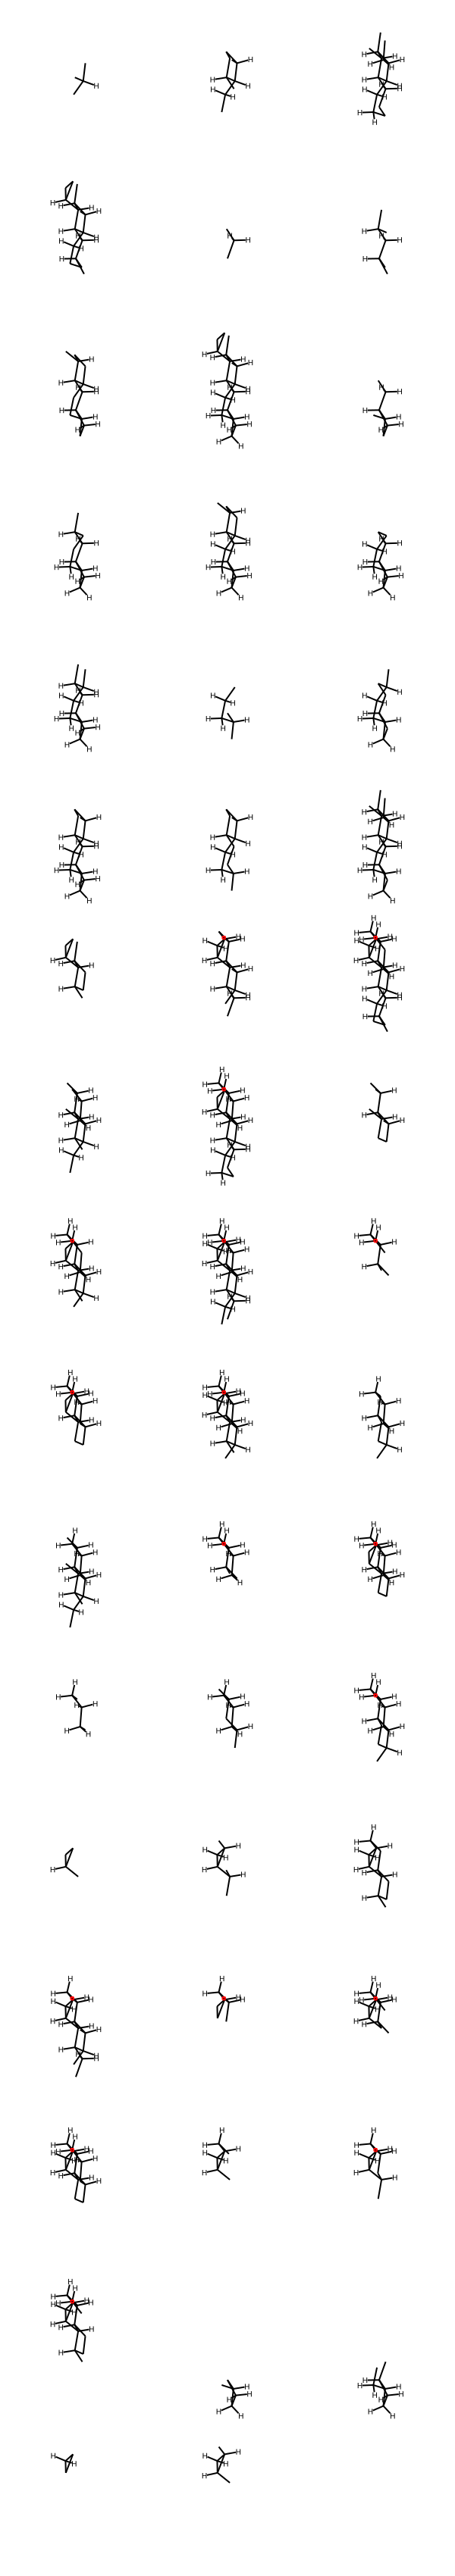

In [5]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(FRAGS)